In [1]:
import numpy as np
import pandas as pd
import shap
from sklearn.metrics import confusion_matrix, classification_report
%config Completer.use_jedi = False

## Use only non-Site variables

In [2]:
# No Site-specific variables
df = pd.read_csv('../../data/csl/CSL_tytl_PI.csv', index_col=0)
#corr_df = pd.read_csv('../../data/csl/Features/PI_Tl_Del_noSiteCorr_abCont_u50.csv', index_col=0, header=None, delimiter='\t')
corr_df = pd.read_csv('../../data/csl/Features/PI_Tl_Del_noSiteCorr.csv', index_col=0, header=None, delimiter='\t')
corr_vars = list(corr_df.index.values)
print(len(corr_vars))
X = df.drop('trans_loss', axis=1, inplace=False)
X = X[corr_vars]
y = df['trans_loss'].values

185


In [3]:
X.head()

,Accrete,Activeherpes,AdmBishop,Admcervpos,Admconsistency,Admcontract,AdmDBP,Admefface,Admpresent,Admreason,...,spontlabor,TD_nos,ThreatenedPB,threatpb9,TrialLabor,UnspecHBP,Urupture,uscar,version9,vertex
MomID,,,,,,,,,,,,,,,,,,,,,
41-00002,0,0,8,8,8,99.0,83,0.0,77,1,...,1,0,0,0,0,0,0,1,0,9
41-00003,0,0,6,3,2,2.9,77,70.0,1,3,...,0,0,0,0,1,0,0,0,0,1
41-00004,0,0,5,3,2,3.3,65,70.0,1,3,...,0,0,0,0,1,0,0,0,0,1
41-00005,0,0,11,2,3,4.0,77,80.0,77,4,...,1,0,0,0,1,0,0,0,0,1
41-00006,0,0,11,1,3,5.0,98,100.0,77,4,...,1,0,0,0,1,0,0,0,0,1


In [5]:
%%time
from mwb_bootstrap import bootstrap_stat_all
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=70, criterion="friedman_mse",max_depth=11, min_samples_leaf=50,
                                     min_samples_split=900,max_leaf_nodes=None,max_features=12,subsample=0.9,
                                     learning_rate=0.1,random_state=7)

# Don't use undersampling - need to keep MomIDs aligned
stats_df, feats_df, X_train, y_train, X_test, y_test, y_pred = bootstrap_stat_all(X, y, clf, sample_weights=True, 
                                                                         nsamples=10, under=False)
stats_df.loc['mean'] = stats_df.mean()
stats_df.loc['mean',:]

CPU times: user 2min 33s, sys: 2.19 s, total: 2min 35s
Wall time: 2min 35s


recall     0.854947
prec       0.136300
MCC        0.257381
PR_AUC     0.218402
roc_auc    0.832162
Name: mean, dtype: float64

In [6]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_pred.shape)

(129789, 185)
(129789,)
(55624, 185)
(55624,)
(55624,)


In [7]:
y_train_pred = clf.predict(X_train)
print(y_train_pred.shape)

(129789,)


In [8]:
print(confusion_matrix(y_test, y_pred))
print(np.floor(confusion_matrix(y_test, y_pred, normalize='all')*10000))
print(confusion_matrix(y_train, y_train_pred))
print(np.floor(confusion_matrix(y_train, y_train_pred, normalize='all')*10000))

[[35754 16767]
 [  423  2680]]
[[6427. 3014.]
 [  76.  481.]]
[[83510 39038]
 [  712  6529]]
[[6434. 3007.]
 [  54.  503.]]


In [12]:
# Get Sitenum data and merge
site_df = pd.read_csv('/MFMDatasets/MFM_bopf/data/csl/CSL_tytl_PI.csv', index_col=0)
Xt_site = site_df[['Sitenum']].merge(X_train, left_index=True, right_index=True, how='right')
Xt_site

,Sitenum,Accrete,Activeherpes,AdmBishop,Admcervpos,Admconsistency,Admcontract,AdmDBP,Admefface,Admpresent,...,spontlabor,TD_nos,ThreatenedPB,threatpb9,TrialLabor,UnspecHBP,Urupture,uscar,version9,vertex
MomID,,,,,,,,,,,,,,,,,,,,,
48-13687,48,0,0,8,8,8,66.0,74,0.0,77,...,0,0,0,0,0,0,0,1,0,1
46-02416,46,0,0,8,8,8,99.0,76,0.0,1,...,0,0,0,0,0,0,0,0,0,1
43-00199,43,0,0,8,8,8,66.0,74,40.0,1,...,1,0,0,0,1,0,0,0,0,1
52-01839,52,0,0,8,8,8,66.0,74,80.0,1,...,1,0,0,0,1,0,0,0,0,1
52-00799,52,0,0,8,8,8,66.0,74,0.0,77,...,0,0,0,0,0,0,0,1,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45-05589,45,0,0,8,3,3,2.0,85,60.0,1,...,0,0,0,0,1,0,0,0,0,1
47-08878,47,0,0,8,8,8,99.0,74,0.0,1,...,1,0,0,0,1,0,0,0,0,1
42-01747,42,0,0,8,8,8,99.0,85,80.0,1,...,1,0,0,0,1,0,0,0,0,1


In [24]:
# Create mask for Site #41
s41_mask = Xt_site['Sitenum'] == 41
s49_mask = Xt_site['Sitenum'] == 49
s44_mask = Xt_site['Sitenum'] == 44

In [25]:
Xtrain_s41 = X_train[s41_mask]
print(Xtrain_s41.shape)
Xtrain_s49 = X_train[s49_mask]
print(Xtrain_s49.shape)
Xtrain_s44 = X_train[s44_mask]
print(Xtrain_s44.shape)

(29975, 185)
(17030, 185)
(11597, 185)


In [13]:
%%time
#explainer = shap.TreeExplainer(clf)
explainer = shap.TreeExplainer(clf, X_train)
shap_values = explainer.shap_values(X_train)
#shap_values = explainer(X_train)

100%|===================| 129655/129789 [11:40<00:00]        

CPU times: user 11min 45s, sys: 4.07 s, total: 11min 49s
Wall time: 11min 42s


In [18]:
%%time
s41_explainer = shap.TreeExplainer(clf, Xtrain_s41)
s41_shap_values = s41_explainer.shap_values(Xtrain_s41)

100%|===================| 29947/29975 [02:06<00:00]        

CPU times: user 2min 6s, sys: 559 ms, total: 2min 6s
Wall time: 2min 5s


In [26]:
%%time
s49_explainer = shap.TreeExplainer(clf, Xtrain_s49)
s49_shap_values = s49_explainer.shap_values(Xtrain_s49)

100%|===================| 16962/17030 [01:13<00:00]        

CPU times: user 1min 13s, sys: 351 ms, total: 1min 13s
Wall time: 1min 12s


In [27]:
%%time
s44_explainer = shap.TreeExplainer(clf, Xtrain_s44)
s44_shap_values = s44_explainer.shap_values(Xtrain_s44)

 98%|===================| 11376/11597 [00:44<00:00]        

CPU times: user 44.7 s, sys: 217 ms, total: 44.9 s
Wall time: 44.5 s


In [20]:
print(type(shap_values))
print(shap_values.shape)
print(type(s41_shap_values))
print(s41_shap_values.shape)

<class 'numpy.ndarray'>
(129789, 185)
<class 'numpy.ndarray'>
(29975, 185)


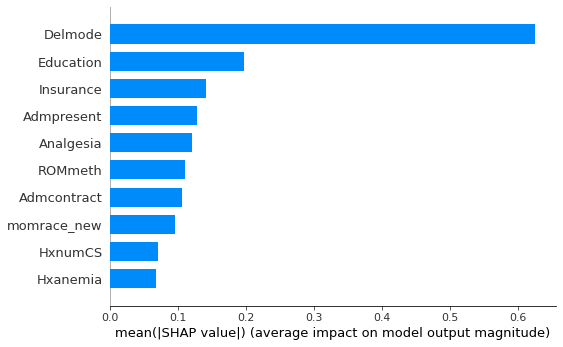

In [37]:
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=10)

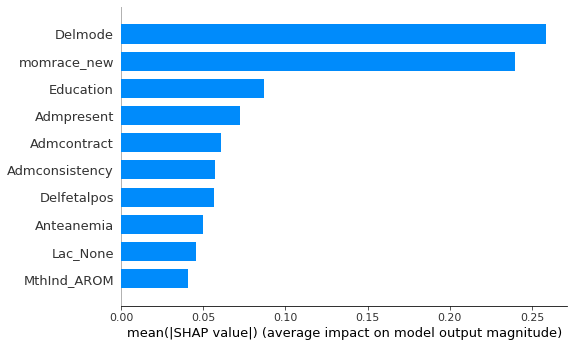

In [38]:
shap.summary_plot(s41_shap_values, Xtrain_s41, plot_type="bar", max_display=10)

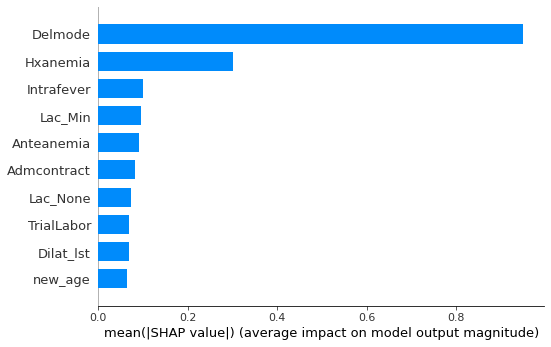

In [39]:
shap.summary_plot(s49_shap_values, Xtrain_s49, plot_type="bar", max_display=10)

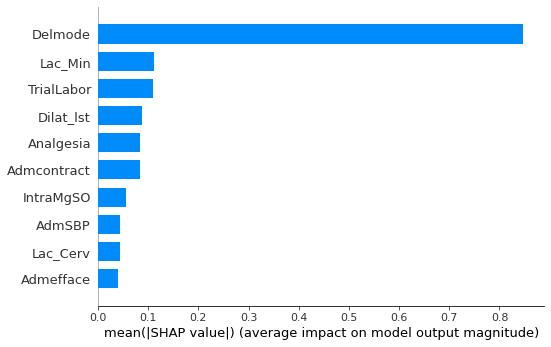

In [40]:
shap.summary_plot(s44_shap_values, Xtrain_s44, plot_type="bar", max_display=10)

In [31]:
def ABS_SHAP(df_shap, df, display_lim=20):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    #df_v = df.copy().reset_index().drop('index',axis=1)
    df_v = df.copy()
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2.tail(display_lim)['Sign']
    ax = k2.tail(display_lim).plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(12,12),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    

invalid value encountered in true_divide
invalid value encountered in true_divide


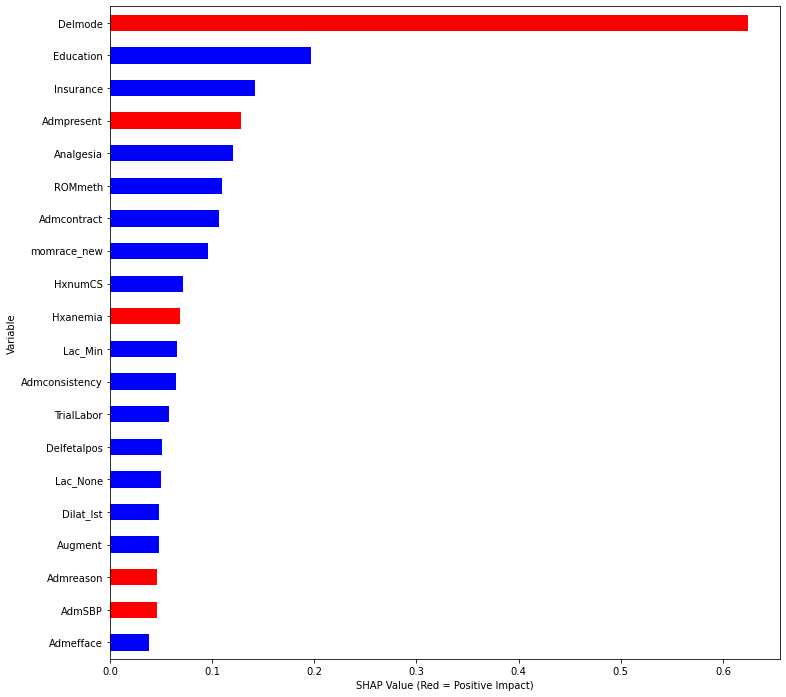

In [32]:
ABS_SHAP(shap_values,X_train)

invalid value encountered in true_divide
invalid value encountered in true_divide


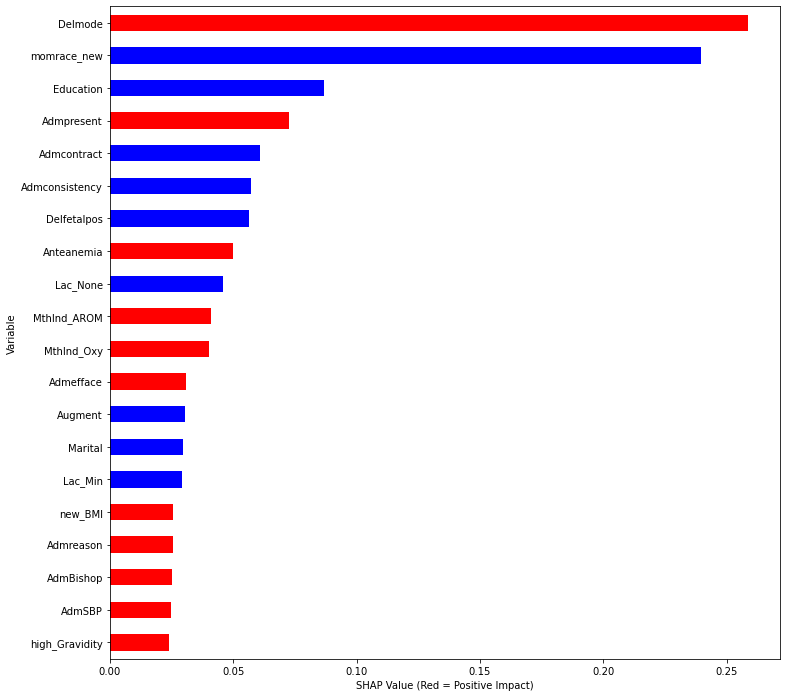

In [34]:
ABS_SHAP(s41_shap_values, Xtrain_s41)

invalid value encountered in true_divide
invalid value encountered in true_divide


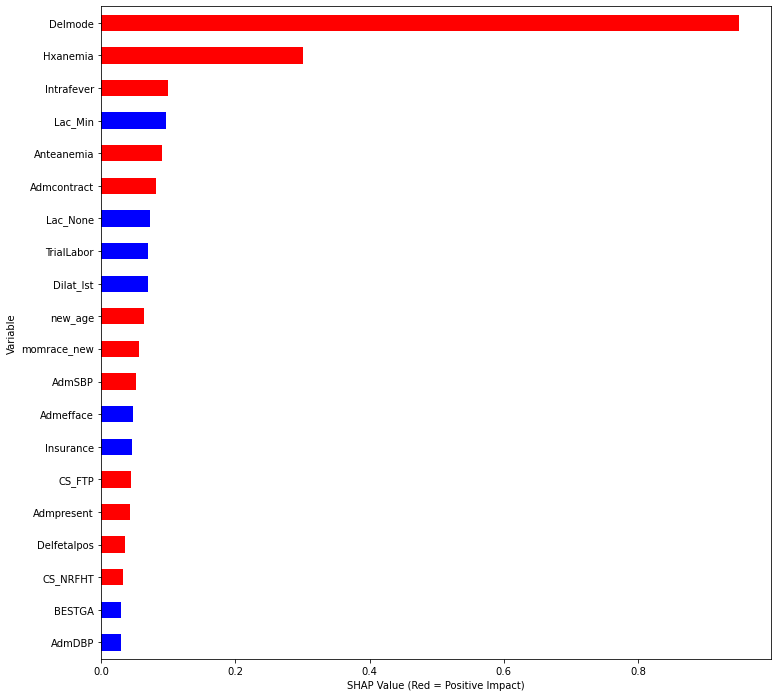

In [35]:
ABS_SHAP(s49_shap_values, Xtrain_s49)

invalid value encountered in true_divide
invalid value encountered in true_divide


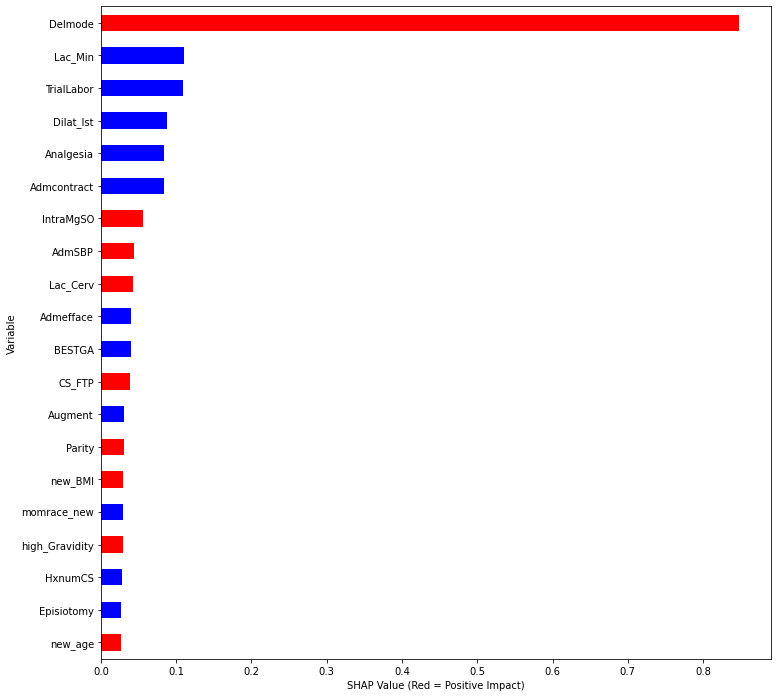

In [36]:
ABS_SHAP(s44_shap_values, Xtrain_s44)

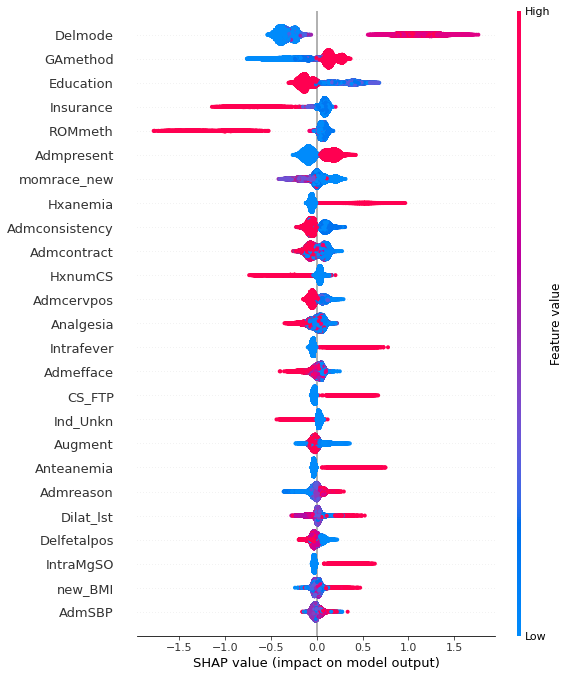

CPU times: user 9.02 s, sys: 110 ms, total: 9.13 s
Wall time: 9.12 s


In [17]:
%%time
shap.summary_plot(shap_values, X_test, max_display=25)

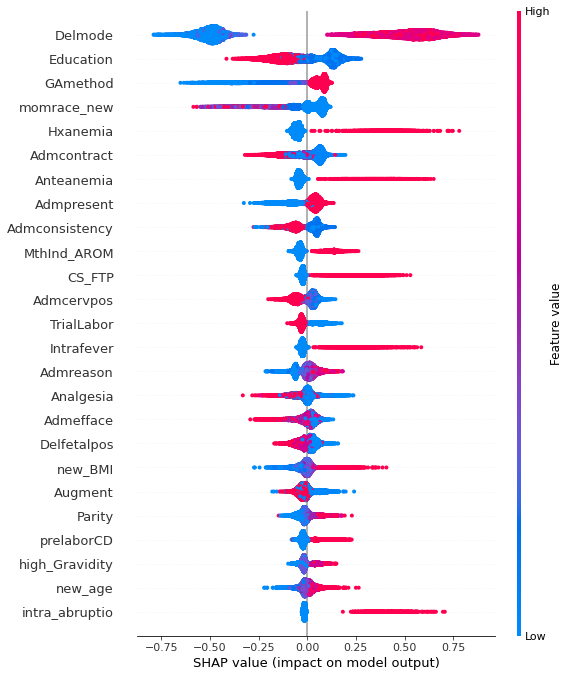

CPU times: user 3.36 s, sys: 34.3 ms, total: 3.39 s
Wall time: 3.39 s


In [32]:
%%time
shap.summary_plot(fp_shap_values, Xt_fp, max_display=25)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


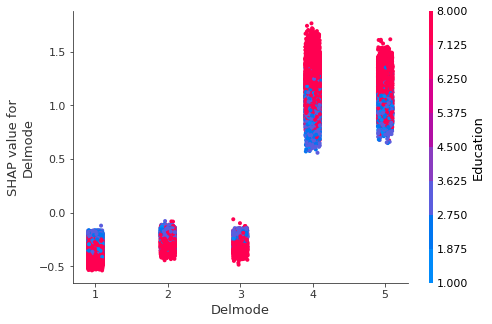

In [18]:
shap.dependence_plot("Delmode", shap_values, X_test, x_jitter=0.2)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


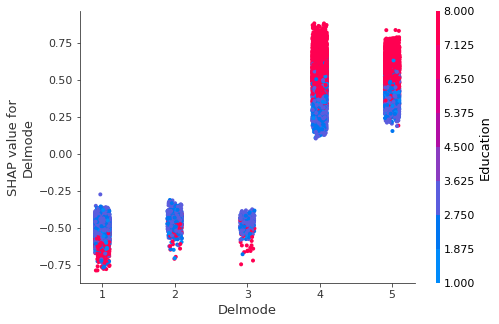

In [34]:
shap.dependence_plot("Delmode", fp_shap_values, Xt_fp, x_jitter=0.2)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


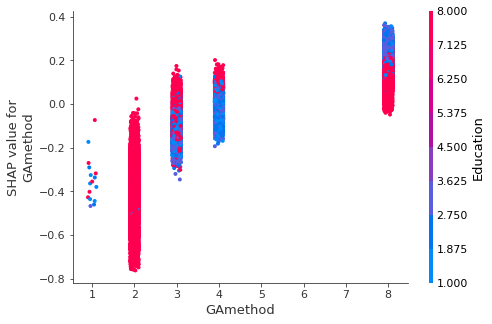

In [35]:
shap.dependence_plot("GAmethod", shap_values, X_test, x_jitter=0.2)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


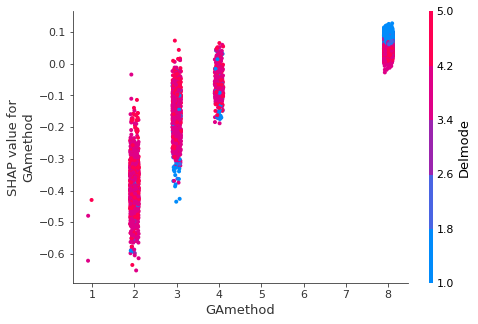

In [36]:
shap.dependence_plot("GAmethod", fp_shap_values, Xt_fp, x_jitter=0.2)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


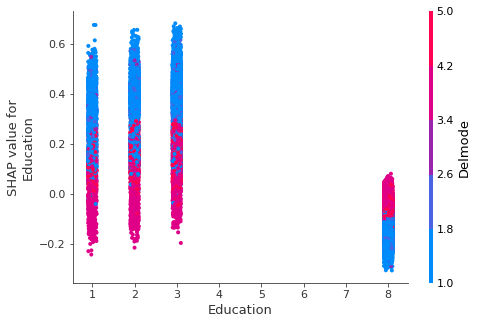

In [37]:
shap.dependence_plot("Education", shap_values, X_test, x_jitter=0.2)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


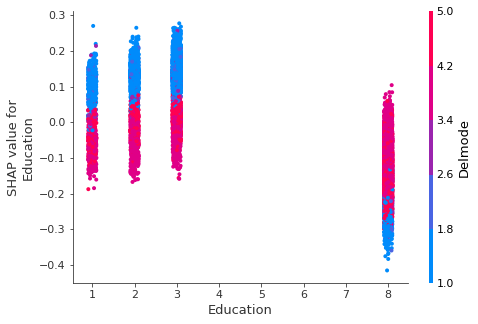

In [38]:
shap.dependence_plot("Education", fp_shap_values, Xt_fp, x_jitter=0.2)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


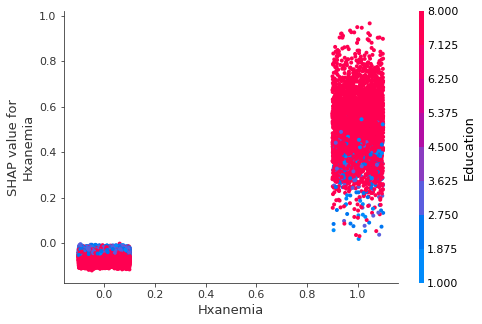

In [39]:
shap.dependence_plot("Hxanemia", shap_values, X_test, x_jitter=0.2)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


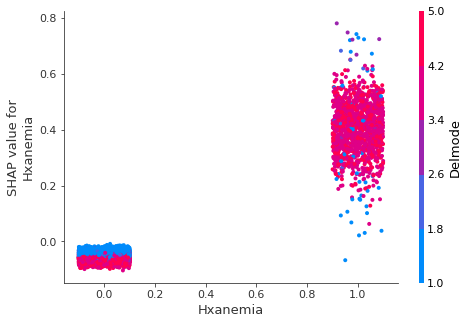

In [40]:
shap.dependence_plot("Hxanemia", fp_shap_values, Xt_fp, x_jitter=0.2)

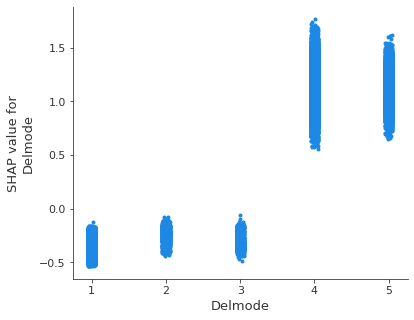

In [41]:
shap.dependence_plot("Delmode", shap_values, X_test, x_jitter=0.1, interaction_index=None)

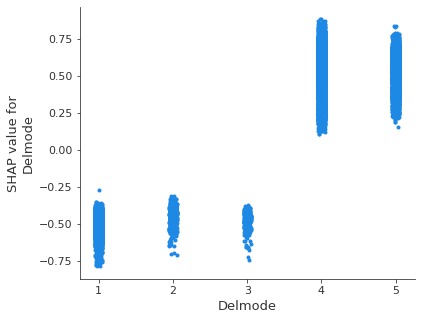

In [42]:
shap.dependence_plot("Delmode", fp_shap_values, Xt_fp, x_jitter=0.1, interaction_index=None)

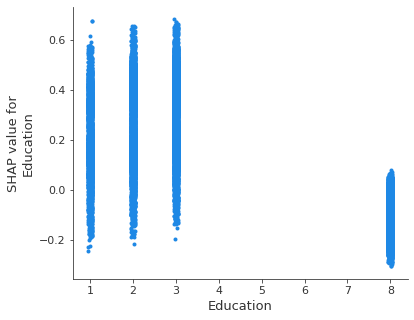

In [43]:
shap.dependence_plot("Education", shap_values, X_test, x_jitter=0.1, interaction_index=None)

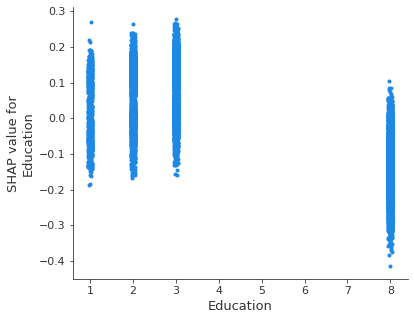

In [44]:
shap.dependence_plot("Education", fp_shap_values, Xt_fp, x_jitter=0.1, interaction_index=None)